In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
lines = []
images = []
measurements = []
correction = 0.2

#Reading CSV File
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

    
# Data Split #Validation 20% 
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

#Using generator to avoid storing the whole data in memory. 
def generator(samples):
    while 1: # Loop forever 
        sklearn.utils.shuffle(samples) #Shuffle Data 
        for x in range(0, len(samples), 128): #Batch with 128
            batch = samples[x:x + 128]
            images = []
            measurements = []
            for line in batch:
                for i in range(3):
                    source_path = line[i]
                    filename = source_path.split('/')[-1]
                    #print(filename)
                    current_path = 'data/IMG/' + filename
                    #print(current_path)
                    #image = cv2.imread(current_path)
                    image = cv2.imread(current_path)[:,:,::-1]  # Read image and convert from BGR to RGB
                    images.append(image)
                    if i == 0:
                        measurement = float(line[3])
                    elif i == 1:
                        measurement = float(line[3]) + correction
                    elif i == 2:
                        measurement = float(line[3]) - correction
                    measurements.append(measurement)
                    #Add Augmented Images and Measurements
                    images.append(cv2.flip(image, 1))
                    measurements.append(measurement * -1.0)
                
            x_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(x_train, y_train)

#Lenth of Sampaly multilpy 3 für left write and center and then by 2 for fliped images
sample_per_epoch = len(train_samples) * 3 * 2
nb_val_sample = len(validation_samples) * 3 * 2

#Generator for Training and Validation Data
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)


In [3]:
#Nvidia Model
# https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/


model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70, 25), (1, 1))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Dropout(0.1)) #Added Dropout to prevent overfiting
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch=sample_per_epoch, validation_data=validation_generator, nb_val_samples=nb_val_sample, nb_epoch=10, verbose=1)

model.save('model.h5')


Epoch 1/10
55614/55614 [==============================] - 538s - loss: 0.0616 - val_loss: 0.0538
Epoch 2/10
55614/55614 [==============================] - 536s - loss: 0.0507 - val_loss: 0.0499
Epoch 3/10
55614/55614 [==============================] - 528s - loss: 0.0476 - val_loss: 0.0481
Epoch 4/10
55614/55614 [==============================] - 529s - loss: 0.0448 - val_loss: 0.0469
Epoch 5/10
55614/55614 [==============================] - 529s - loss: 0.0426 - val_loss: 0.0455
Epoch 6/10
55614/55614 [==============================] - 529s - loss: 0.0402 - val_loss: 0.0438
Epoch 7/10
55614/55614 [==============================] - 530s - loss: 0.0382 - val_loss: 0.0419
Epoch 8/10
55614/55614 [==============================] - 530s - loss: 0.0366 - val_loss: 0.0415
Epoch 9/10
55614/55614 [==============================] - 530s - loss: 0.0357 - val_loss: 0.0410
Epoch 10/10
55614/55614 [==============================] - 531s - loss: 0.0345 - val_loss: 0.0405


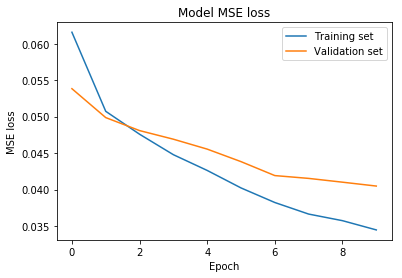

In [4]:
# Output visualization
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model MSE loss')
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.show()


In [5]:
#Visualiation not working installed pydot and graphviz
#ImportError: No module named 'keras.utils.dot_utils'
#Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


from IPython.display import Image, display, SVG
from keras.utils.visualize_util import model_to_dot

# Show the model in ipython notebook
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

# Save the model as png file
from keras.utils.visualize_util import plot
plot(model, to_file='model.png', show_shapes=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.